# $Baseline$ $Model$ $Training$

In [1]:
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.model_selection import train_test_split,StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from category_encoders import TargetEncoder
import pandas as pd

In [2]:
try:
    df = pd.read_csv('../data/Processed_CollegePlacement.csv')
except FileNotFoundError:
    print('File Not Found! Please check file path and try again!')

In [3]:
x = df.drop(columns=['Placement']).copy()
y = df['Placement'].copy()

In [4]:
y.value_counts()

Placement
0    8341
1    1659
Name: count, dtype: int64

$Insight$ ~ `Class samples are imbalanced`

In [5]:
# train - test split
x_train,x_test,y_train,y_test = train_test_split(
    x, y, test_size=0.3, stratify=y
)

x_train.to_csv('../data/x_train.csv',index=False)
x_test.to_csv('../data/x_test.csv',index=False)
y_train.to_csv('../data/y_train.csv',index=False)
y_test.to_csv('../data/y_test.csv',index=False)

In [6]:
numeric_cols = x_train.select_dtypes(include=[np.number]).columns
category_cols = x_train.select_dtypes(exclude=[np.number]).columns

In [7]:
# preprocessing and feature scaling
num_cols = Pipeline(steps=[
    ('poly',PolynomialFeatures(include_bias=False)),
    ('scaler',StandardScaler()),
])

cat_cols = Pipeline(steps=[
    ('target_encode',TargetEncoder())
])

In [8]:
preprocessor = ColumnTransformer(transformers=[
    ('num',num_cols,numeric_cols),
    ('cat',cat_cols,category_cols)
],verbose_feature_names_out=False)

In [9]:
# baseline models
name_models = {
    'Logistic_Regression' : LogisticRegression(penalty='l1',class_weight='balanced',random_state=42,max_iter=1000,solver='saga'),
    'Decision_Tree' : DecisionTreeClassifier(random_state=537,class_weight='balanced'),
    'Random_Forest' : RandomForestClassifier(random_state=537,class_weight='balanced'),
    'XGBoost' : XGBClassifier(objective='binary:logistic',random_state=42)
}

cv = StratifiedKFold(n_splits=5,shuffle=True,random_state=537)

results = {}
for name, models in name_models.items():
    print(f'Training {name}.This May Take A While...')
    pipe = Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('classifier',models)
    ])

    cv_score = cross_val_score(pipe, x_train, y_train, cv = cv, scoring='accuracy', n_jobs=-1,verbose=1)

    results[name] = {
        'CV accuracy across folds' : cv_score,
        'CV mean score' : cv_score.mean(),
        'CV std score' : cv_score.std()
    }
    print('-'*50)


for name, result in results.items():
    print(f'Model : {name}')
    print('cv across folds : ',result['CV accuracy across folds'])
    print('cv mean : ',result['CV mean score'])
    print('cv std : ',result['CV std score'])
    print('-'*50)

Training Logistic_Regression.This May Take A While...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   12.6s remaining:   19.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   16.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


--------------------------------------------------
Training Decision_Tree.This May Take A While...


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


--------------------------------------------------
Training Random_Forest.This May Take A While...


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.8s remaining:    2.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


--------------------------------------------------
Training XGBoost.This May Take A While...
--------------------------------------------------
Model : Logistic_Regression
cv across folds :  [0.88714286 0.89857143 0.885      0.895      0.89071429]
cv mean :  0.8912857142857142
cv std :  0.0049775003971955336
--------------------------------------------------
Model : Decision_Tree
cv across folds :  [1.         0.99928571 1.         0.99785714 0.99928571]
cv mean :  0.9992857142857143
cv std :  0.0007824607964359406
--------------------------------------------------
Model : Random_Forest
cv across folds :  [1.         1.         0.99928571 1.         1.        ]
cv mean :  0.9998571428571429
cv std :  0.0002857142857142669
--------------------------------------------------
Model : XGBoost
cv across folds :  [0.99785714 0.99928571 1.         1.         1.        ]
cv mean :  0.9994285714285714
cv std :  0.0008329931278350301
--------------------------------------------------


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


In [11]:
# Tuning the best model (XGBoost)
xgb_pipe = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('classifier',XGBClassifier(objective='binary:logistic', random_state = 537))
])

negative_class = (y_train == 0).sum()
positive_class = (y_train == 1).sum()
scale_pos_weight  = negative_class / positive_class


xgb_params_grid = {
    'classifier__n_estimators' : [80,100,120],
    'classifier__max_depth' : [2,4,6],
    'preprocessor__num__poly__degree' : [1,2],
    'classifier__learning_rate' : [0.01,0.05,0.1],
    'classifier__scale_pos_weight' : [scale_pos_weight * 0.8,
                                    scale_pos_weight,
                                    scale_pos_weight * 1.2]
}

model = GridSearchCV(estimator=xgb_pipe, param_grid=xgb_params_grid, scoring= 'accuracy', refit= True, n_jobs = -1,cv=cv)
model.fit(x_train,y_train)

print('Best Score : ',model.best_score_)
print('Best Params : ',model.best_params_)

Best Score :  1.0
Best Params :  {'classifier__learning_rate': 0.01, 'classifier__max_depth': 4, 'classifier__n_estimators': 80, 'classifier__scale_pos_weight': np.float64(4.023428079242033), 'preprocessor__num__poly__degree': 1}


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_score,recall_score,confusion_matrix,accuracy_score

In [13]:
best_model_ = model.best_estimator_

In [14]:
# prediction
y_probs = best_model_.predict_proba(x_test)[:,1]
threshold = 0.5
y_pred = (y_probs >= threshold).astype(int)

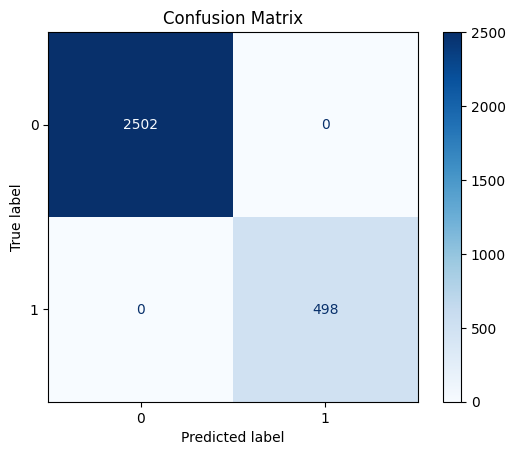

In [15]:
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=np.unique(y_test))
disp.plot(cmap = 'Blues')
plt.title('Confusion Matrix')
plt.show()